<a href="https://colab.research.google.com/github/robinmollah/PeraNaiChill/blob/master/Thesis_Rumex_Leaves_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Mount***

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
root_dir = "/content/drive/MyDrive/Thesis Rumex Leave-SUB/RumexLeaves/iNaturalist/"

In [4]:
!ls "/content/drive/MyDrive/Thesis Rumex Leave-SUB" #check the current directory

RumexLeaves


***Images Resized***

In [5]:
!ls -1 "/content/drive/MyDrive/Thesis Rumex Leave-SUB/RumexLeaves/iNaturalist/" | grep ".*.jpg" | wc -l

240


In [6]:
import cv2
import os

def resize_images(source, dest):
  files = os.listdir(source)
  if len(files) == 0:
    raise Exception(f"Directory is not correct")
  print(f"{len(files)} images will be resized")
  for filename in files:
    try:
      img = cv2.imread(f"{source}/{filename}")
      resized_img = cv2.resize(img, (224, 224))
      cv2.imwrite(f"{dest}/{filename}", resized_img)
    except Exception as e:
      print(f"{source}{filename} could not be resized. {e}")

#resize_images(f"{root_dir}", f"{root_dir}images_resized")

In [7]:
!ls -1 '/content/drive/MyDrive/Thesis Rumex Leave-SUB/RumexLeaves/iNaturalist/images_resized' | wc -l

693


# **Annotation Part**

# **part 2**

In [8]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

def focal_loss(y_true, y_pred):
    alpha=0.25
    gamma=2
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

In [9]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS=3
EPOCHS = 1
BATCH = 2
LR = 0.001
shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
PATH = "/content/drive/MyDrive/Thesis Rumex Leave-SUB/RumexLeaves"

def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

In [10]:
path = "/content/drive/MyDrive/Thesis Rumex Leave-SUB/RumexLeaves/iNaturalist"


In [11]:

augmented_dir = root_dir+"/augment_data/"
os.makedirs(augmented_dir, exist_ok=True)

In [12]:
# 1. Load the dataset
# 2. Use the albumentations library to augment the dataset.

import os
import cv2
from tqdm import tqdm
from glob import glob
from albumentations import RandomBrightnessContrast, CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip, Transpose, Compose, RandomGamma, RGBShift, RandomContrast, HueSaturationValue, RandomBrightness

def load_data():
    images = sorted(glob(os.path.join(path, "images_resized/*")))
    masks = sorted(glob(os.path.join(path, "masks_resized/*")))
    num_image = len(images)
    num_masks = len(masks)
    if len(images) == 0 and len(masks) == 0:
      raise Exception(f"Folder paths are incorrect. Images: {num_image} Masks: {num_masks}")
    return images, masks

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def augment_data(images, masks, save_path, augment=True):
    H = 224
    W = 224

    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        """ Extracting the name and extension of the image and the mask. """
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]

        """ Reading image and mask. """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_GRAYSCALE) # Expecting grayscale - bw image
        (thresh, y) = cv2.threshold(y, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        """ Augmentation """
        if augment == True:
            aug = RandomRotate90(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            aug = RandomRotate90(p=0.5)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            aug = GridDistortion(p=1.0)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x6 = augmented['image']
            y6 = augmented['mask']

            aug = Transpose(p=1.0)
            augmented = aug(image=x, mask=y)
            x7 = augmented['image']
            y7 = augmented['mask']

            aug = Compose([VerticalFlip(p=0.5),RandomRotate90(p=0.5)])
            augmented = aug(image=x, mask=y)
            x8 = augmented['image']
            y8 = augmented['mask']

            aug = RandomBrightnessContrast(p=1)
            augmented = aug(image=x, mask=y)
            x9 = augmented['image']
            y9 = augmented['mask']

            aug = RandomGamma(p=1)
            augmented = aug(image=x, mask=y)
            x10 = augmented['image']
            y10 = augmented['mask']

            aug = HueSaturationValue(p=1)
            augmented = aug(image=x, mask=y)
            x11 = augmented['image']
            y11 = augmented['mask']

            aug = RGBShift(p=1)
            augmented = aug(image=x, mask=y)
            x12 = augmented['image']
            y12 = augmented['mask']

            aug = RandomBrightness(p=1)
            augmented = aug(image=x, mask=y)
            x13 = augmented['image']
            y13 = augmented['mask']

            # aug = RandomContrast(p=1)
            # augmented = aug(image=x, mask=y)
            # x14 = augmented['image']
            # y14 = augmented['mask']

            # save_images = [x, x2, x3]
            # save_masks =  [y, y2, y3]

            save_images = [x, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13]
            save_masks =  [y, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11, y12, y13]

        else:
            save_images = [x]
            save_masks = [y]

        """ Saving the image and mask. """
        idx = 0
        for i, m in zip(save_images, save_masks):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            if len(images) == 1:
                tmp_img_name = f"{image_name}.{image_extn}"
                tmp_mask_name = f"{mask_name}.{mask_extn}"
            else:
                tmp_img_name = f"{image_name}_{idx}.{image_extn}"
                tmp_mask_name = f"{mask_name}_{idx}.{mask_extn}"

            image_path = os.path.join(save_path, "images", tmp_img_name)
            mask_path = os.path.join(save_path, "masks", tmp_mask_name)
            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1

def create_dirs(r_dir):
  os.makedirs(r_dir, exist_ok=True)
  os.makedirs(f"{r_dir}images", exist_ok=True)
  os.makedirs(f"{r_dir}masks", exist_ok=True)


def aug_data():
    """ Loading original images and masks. """
    create_dirs(augmented_dir)
    images, masks = load_data()
    print(f"Original Images: {len(images)} - Original Masks: {len(masks)}")

    """ Applying data augmentation. """
    augment_data(images, masks, augmented_dir, augment=True)

    """ Loading augmented images and masks. """
    images, masks = os.listdir(f"{augmented_dir}images"), os.listdir(f"{augmented_dir}masks"),
    print(f"\nAugmented Images: {len(images)} - Augmented Masks: {len(masks)}")


# aug_data()

In [13]:
path = root_dir




In [14]:
# prompt: rint(augmented_dir) images, masks = os.listdir(augmented_dir + "images"), os.listdir(augmented_dir + "masks") print(f"Augmented Images: {len(images)} - Augmented Masks: {len(masks)}")  Find the error and rewrite the code

augmented_dir = "/new_data/"
create_dirs(augmented_dir)
images, masks = load_data()
print(f"Original Images: {len(images)} - Original Masks: {len(masks)}")

""" Applying data augmentation. """
augment_data(images, masks, augmented_dir, augment=True)

""" Loading augmented images and masks. """
images, masks = os.listdir(f"{augmented_dir}images"), os.listdir(f"{augmented_dir}masks")
print(f"\nAugmented Images: {len(images)} - Augmented Masks: {len(masks)}")


Original Images: 693 - Original Masks: 690


  0%|          | 0/693 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
100%|█████████▉| 690/693 [06:32<00:01,  1.76it/s]


Augmented Images: 8970 - Augmented Masks: 8970


In [15]:
images_resized = len(os.listdir(root_dir + "/images_resized"))
masks_resized = len(os.listdir(root_dir + "/masks_resized"))
augmented_images = len(os.listdir(augmented_dir + "images"))
augmented_masks = len(os.listdir(augmented_dir + "masks"))
images_resized, masks_resized, augmented_images, augmented_masks

(693, 690, 8970, 8970)

In [16]:
from sklearn.model_selection import train_test_split


def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))

    total_size = len(images)
    print("total image", total_size)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

# load_data(augmented_dir)

In [17]:
# # New preprocessing code # #

def read_image(x):
    x = x.decode()
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = np.clip(image - np.median(image)+127, 0, 255)
    image = image/255.0
    image = image.astype(np.float32)
    return image

def read_mask(y):
    y = y.decode()
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = mask/255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

def parse_data(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        y = np.concatenate([y, y], axis=-1)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([224, 224, 3])
    y.set_shape([224, 224, 2])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=32)
    dataset = dataset.map(map_func=parse_data)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch)
    return dataset

In [18]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(augmented_dir)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

print("Training masks: ", len(train_y))
print("Validation masks: ", len(valid_y))
print("Testing masks: ", len(test_y))

total image 8970
Training data:  7176
Validation data:  897
Testing data:  897
Training masks:  7176
Validation masks:  897
Testing masks:  897


In [19]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x


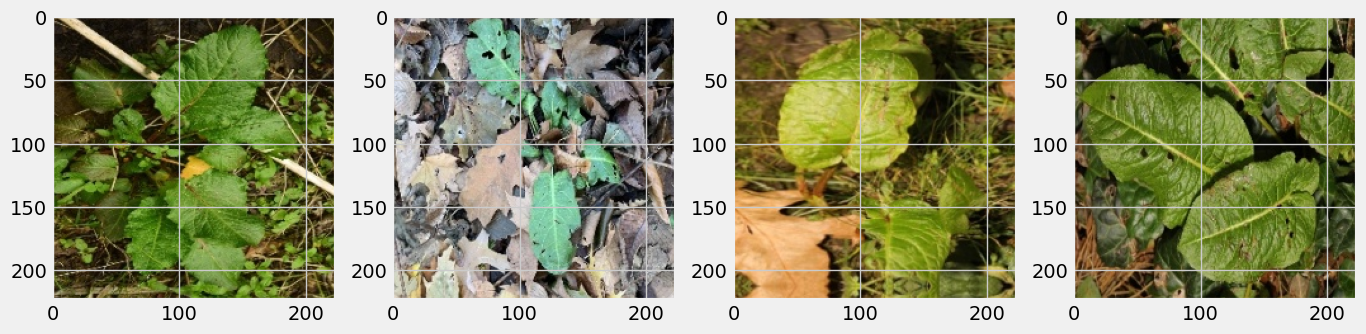

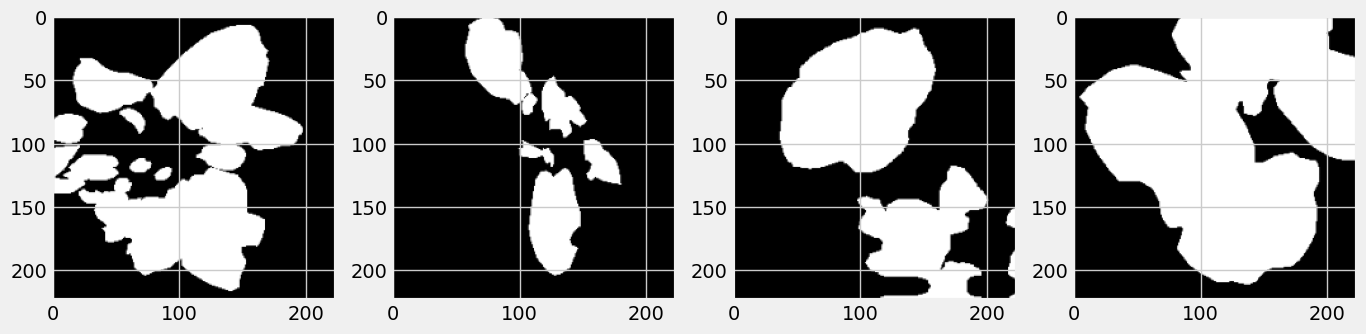

In [20]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[91]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[181]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[271]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[335]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[91]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[181]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[271]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[335]))
imgplot.set_clim(0.0, 1.4)

# **Training**

In [21]:
create_dir("files")
model_path = os.path.join("files", "VGG16.hdf5")
csv_path = os.path.join("files", "VGG16_history.csv")

In [22]:
import keras
!pip install keras-self-attention
from keras_self_attention import SeqSelfAttention
from tensorflow.keras import layers

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=13f452579f8ee6a3644ba92734e5f308db3dfdeae2b3dffe94b293a315743c57
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [23]:
from tensorflow.keras.applications import ResNet101V2, ResNet50V2, EfficientNetV2B3, EfficientNetB5, EfficientNetV2B0, InceptionResNetV2, DenseNet121, MobileNetV2,ResNet50,VGG16,VGG19, NASNetLarge,EfficientNetB7,EfficientNetV2S, EfficientNetV2M,EfficientNetV2L
import tensorflow as tf

tf.keras.backend.clear_session()

model = VGG16(include_top=False, weights='imagenet',  input_shape=(224, 224, 3))

model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [24]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip,  RandomBrightnessContrast
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, Bidirectional, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, ZeroPadding2D,ConvLSTM2D,LSTM,GlobalAveragePooling2D, Reshape, Dense, Multiply, AveragePooling2D, UpSampling2D
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate,TimeDistributed, Add, GlobalMaxPooling2D, Multiply, Permute, multiply
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications import InceptionResNetV2, DenseNet121, MobileNetV2,ResNet50,VGG16,VGG19, NASNetLarge,EfficientNetB7,EfficientNetV2S, EfficientNetV2M,EfficientNetV2L
from tensorflow.keras.metrics import Recall, Precision, Accuracy, MeanIoU
from tensorflow.keras import backend as K

In [25]:
# Ref : https://github.com/bnsreenu/python_for_microscopists

def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return tf.keras.layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def gating_signal(inputs, out_size):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = tf.keras.layers.Conv2D(out_size, (1, 1), padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x


def attention_block(x, gating, inter_shape):

    # print("from attention block - x " , x.shape)
    # print("from attention block - gating " , x.shape)

    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = tf.keras.layers.Conv2D(inter_shape, (1, 1), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = tf.keras.layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)

    upsample_g = tf.keras.layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = tf.keras.layers.add([upsample_g, theta_x])
    act_xg = tf.keras.layers.Activation('relu')(concat_xg)

    psi = tf.keras.layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = tf.keras.layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    act_xg1 = channel_attention(act_xg)
    act_xg2 = squeeze_excite_block(act_xg)
    act_xg3 = spatial_attention_block(act_xg)

    x1 = tf.keras.layers.concatenate([act_xg1, act_xg2, act_xg3])
    x1 = UpSampling2D((2, 2), interpolation='bilinear')(x1)

    upsample_psi = tf.keras.layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32
    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = tf.keras.layers.concatenate([x1, x, upsample_psi])

    result = tf.keras.layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = tf.keras.layers.BatchNormalization()(result)
    return result_bn


def multi_kernel_convolution(x, filter):
    shape = x.shape

    y2 = tf.keras.layers.Conv2D(filter, 1,  padding="same", use_bias=False)(x)
    y2 = tf.keras.layers.BatchNormalization()(y2)
    y2 = tf.keras.layers.Activation("relu")(y2)

    y3 = tf.keras.layers.Conv2D(filter, 3,padding="same", use_bias=False)(x)
    y3 = tf.keras.layers.BatchNormalization()(y3)
    y3 = tf.keras.layers.Activation("relu")(y3)

    y4 = tf.keras.layers.Conv2D(filter, 5, padding="same", use_bias=False)(x)
    y4 = tf.keras.layers.BatchNormalization()(y4)
    y4 = tf.keras.layers.Activation("relu")(y4)

    y5 = tf.keras.layers.Conv2D(filter, 7, padding="same", use_bias=False)(x)
    y5 = tf.keras.layers.BatchNormalization()(y5)
    y5 = tf.keras.layers.Activation("relu")(y5)

    y6 = tf.keras.layers.Conv2D(filter, 9, padding="same", use_bias=False)(x)
    y6 = tf.keras.layers.BatchNormalization()(y6)
    y6 = tf.keras.layers.Activation("relu")(y6)


    y = tf.keras.layers.Concatenate()([y2, y3, y4, y5, y6])

    y = tf.keras.layers.Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation("relu")(y)

    x1  = Conv2D(1,  1, padding="same", strides=1)(x)
    x1 = BatchNormalization()(x1)
    s = Concatenate()([x1, y])
    s = Activation("relu")(s)

    return s



def channel_attention(x, ratio=8):
    batch, _, _, channel = x.shape

    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats


tf.keras.backend.clear_session()
def squeeze_excite_block(inputs, ratio=16):
    init = inputs       ## (b, 128, 128, 32)
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)     ## (b, 32)   -> (b, 1, 1, 32)
    se = Reshape(se_shape)(se)
    se = Dense(filters//ratio, activation="relu", use_bias=False)(se)
    se = Dense(filters, activation="sigmoid", use_bias=False)(se)

    x = Conv2D(1, 1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Multiply()([x, se])
    return x


def spatial_attention_block(inputs):
    """
    Spatial Attention Module utilizing the inter-spatial relationship of features.
    """
    kernel_size = 7

    avg_pool = K.mean(inputs, axis=-1, keepdims=True)
    max_pool = K.max(inputs, axis=-1, keepdims=True)

    x = Concatenate()([avg_pool, max_pool])

    x = Conv2D(1, kernel_size, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(x)

    outputs = Multiply()([inputs, x])
    return outputs


def ASPP(x, filter):
    shape = x.shape

    y1 = tf.keras.layers.AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = tf.keras.layers.Conv2D(filter, 1, padding="same")(y1)
    y1 = tf.keras.layers.BatchNormalization()(y1)
    y1 = tf.keras.layers.Activation("relu")(y1)
    y1 = tf.keras.layers.UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)
    y1 = squeeze_excite_block(y1)

    y2 = tf.keras.layers.Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = tf.keras.layers.BatchNormalization()(y2)
    y2 = tf.keras.layers.Activation("relu")(y2)
    y2 = squeeze_excite_block(y2)

    y3 = tf.keras.layers.Conv2D(filter, 3, dilation_rate=2, padding="same", use_bias=False)(x)
    y3 = tf.keras.layers.BatchNormalization()(y3)
    y3 = tf.keras.layers.Activation("relu")(y3)
    y3 = squeeze_excite_block(y3)

    y4 = tf.keras.layers.Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y4 = tf.keras.layers.BatchNormalization()(y4)
    y4 = tf.keras.layers.Activation("relu")(y4)
    y4 = squeeze_excite_block(y4)

    y5 = tf.keras.layers.Conv2D(filter, 3, dilation_rate=10, padding="same", use_bias=False)(x)
    y5 = tf.keras.layers.BatchNormalization()(y5)
    y5 = tf.keras.layers.Activation("relu")(y5)
    y5 = squeeze_excite_block(y5)

    y6 = tf.keras.layers.Conv2D(filter, 3, dilation_rate=13, padding="same", use_bias=False)(x)
    y6 = tf.keras.layers.BatchNormalization()(y6)
    y6 = tf.keras.layers.Activation("relu")(y6)
    y6 = squeeze_excite_block(y6)

    y7 = tf.keras.layers.Conv2D(filter, 3, dilation_rate=16, padding="same", use_bias=False)(x)
    y7 = tf.keras.layers.BatchNormalization()(y7)
    y7 = tf.keras.layers.Activation("relu")(y7)
    y7 = squeeze_excite_block(y7)

    y = tf.keras.layers.Concatenate()([y1, y2, y3, y4, y5, y6, y7])

    y = tf.keras.layers.Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation("relu")(y)
    # y = squeeze_excite_block(y)

    return y


def residual_conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    shortcut = Conv2D(num_filters, 1, dilation_rate=1, padding='same',strides=1)(input)
    shortcut = BatchNormalization(axis=3)(shortcut)
    res_path = Concatenate()([shortcut, x])
    res_path = Activation("relu")(res_path)

    #Stochastic depth
    # drop_depth = tfa.layers.StochasticDepth(drop_path) if drop_path > 0.0 else layers.Activation("linear")
    # output = layers.Add()([res_path, drop_depth(x)])

    x1 = squeeze_excite_block(res_path)
    x2 = spatial_attention_block(res_path)
    x3 = channel_attention(res_path)

    x = Concatenate()([x1, x2, x3])

    return x


tf.keras.backend.clear_session()
def encoder1(inputs):
    skip_connections = []

    model = VGG16(include_top=False, weights='imagenet', input_tensor=inputs, input_shape=(256, 256, 3))
    names = ["input_1", "block1_pool", "block2_pool", "block3_pool"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv2").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [2, 112, 56, 28]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        gating = gating_signal(x, num_filters[i])
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        att = attention_block(tf.convert_to_tensor(skip_connections[i]), gating, num_filters[i])
        x = Concatenate()([x, att])
        x = residual_conv_block(x, f)

    return x

#def encoder2(inputs):
#  skip_connections = []

#  output = DenseNet121(include_top=False, weights='imagenet')(inputs)
#  model = tf.keras.models.Model(inputs, output)

#  names = ["input_2", "conv1/relu", "pool2_conv", "pool3_conv"]
#  for name in names:
#    skip_connections.append(model.get_layer(name).output)
#    output = model.get_layer("pool4_conv").output

#    return output, skip_connections

def encoder2(inputs):
    num_filters = [28, 56, 112, 224]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = residual_conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [224, 112, 56, 28]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        gating = gating_signal(x, num_filters[i])
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        skip1_att = attention_block(tf.convert_to_tensor(skip_1[i]), gating, num_filters[i])
        skip2_att = attention_block(tf.convert_to_tensor(skip_2[i]), gating, num_filters[i])
        x = Concatenate()([x, skip1_att, skip2_att])
        x = residual_conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return tf.keras.layers.Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = multi_kernel_convolution(x, 64)
    x = ASPP(x, 64)
    x1 = squeeze_excite_block(x)
    x2 = spatial_attention_block(x)
    x3 = channel_attention(x)
    x = Concatenate()([x1,x2,x3])

    # gating = gating_signal(x, 64)
    # att = attention_block(tf.convert_to_tensor(skip_1), gating, 64)

    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = multi_kernel_convolution(x, 64)
    x = ASPP(x, 64)
    x1 = squeeze_excite_block(x)
    x2 = spatial_attention_block(x)
    x3 = channel_attention(x)
    x = Concatenate()([x1,x2,x3])
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    outputs = Concatenate()([outputs1, outputs2])

    model = Model(inputs, outputs)
    return model

if __name__ == "__main__":
    model = build_model((224, 224, 3))

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [27]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.707222 to fit



In [28]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred):
    alpha=0.25
    gamma=2
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)


In [33]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

opt = tf.keras.optimizers.Nadam(LR)
metrics = ['accuracy', dice_coef, Recall(), Precision(), iou, MeanIoU(num_classes=2)]
# metrics = [dice_coef, Recall(), Precision(), iou, MeanIoU(num_classes = 2)]
model.compile(loss=bce_dice_loss, optimizer=opt, metrics=metrics)

os.makedirs("/content/checkpoints")
checkpoint_filepath = "/content/checkpoints/model-{epoch:02d}-{val_loss:.2f}.hdf5"
hist_csv_file = '/content/checkpoints/VGG16_history.csv'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_dice_coef',
    mode='max',
    # save_best_only=True
    )

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10),
    CSVLogger(hist_csv_file),
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    model_checkpoint_callback]

In [34]:
if os.path.exists(model_path):
  model.load_weights(checkpoint_filepath)


In [35]:
train_steps = len(train_x)//BATCH//5
valid_steps = len(valid_x)//BATCH//5
train_steps, valid_steps

(717, 89)

* Emotion express na korte para
* Non techincal interaction with human
* I get hurt.
* আমি অনেক খ্যাত

In [36]:
train_steps = len(train_x)//BATCH//30
valid_steps = len(valid_x)//BATCH//30

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

hist=model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)




119/119 [==============================] - 325s 726ms/step - loss: 0.5882 - accuracy: 0.3881 - dice_coef: 0.7252 - recall_1: 0.8030 - precision_1: 0.7863 - iou: 0.5793 - mean_io_u_1: 0.3600 - val_loss: 1.3911 - val_accuracy: 0.0622 - val_dice_coef: 0.2795 - val_recall_1: 0.0460 - val_precision_1: 0.9961 - val_iou: 0.1647 - val_mean_io_u_1: 0.3586 - lr: 0.0010


# 🥳🥳🥳 Congratulations 🥳🥳🥳

In [ ]:
!ls /content

In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

***MAIN***

In [ ]:
# Plot training & validation accuracy values
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.grid('on')
plt.show()


# Plot training & validation loss values
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.grid('on')
plt.show()

# Plot training & validation dice coefficient values
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(hist['dice_coef'])
plt.plot(hist['val_dice_coef'])
plt.title('Dice Value')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.grid('on')
plt.show()


# Plot training & validation model_iou values
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(hist['iou'])
plt.plot(hist['val_iou'])
plt.title('Model IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.grid('on')
plt.show()
